In [3]:
from __future__ import print_function, division, absolute_import
import marvin
from marvin.tools.maps import Maps
from marvin.tools.image import Image
from marvin import config
from marvin.tools.cube import Cube
from marvin.tools.query import Query
from marvin.utils.datamodel.query.MPL import DR15
from marvin.utils.general.general import getSpaxel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import torch
from torch.autograd import Variable
plt.ion()
#Defining class to do linear regession using torch NN 
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

plt.ion()

#set config attributes and turn on global downloads of Marvin data
config.setRelease('DR15')
config.mode = 'local'
config.download = True


In [8]:
#Importing All MaNGA Data from DPRall Schema
data=pd.read_csv('CompleteTable.csv')


galaxy_list=np.loadtxt('Query Results',dtype=str)
#Pulling mass and SFR for galaxies from Cas Jobs table
galaxy_index=np.zeros(len(galaxy_list))

for i in range (len(galaxy_list)):
    galaxy_index[i]=np.where(data.loc[:,'mangaid']==galaxy_list[i])[0][0]

galaxy_index=np.array(galaxy_index,dtype=int)



galaxies=data.iloc[galaxy_index]

mass=galaxies.loc[:,'nsa_sersic_mass']
log_mass=np.log10(mass)

SFR=galaxies.loc[:,'sfr_tot']
log_SFR=np.log10(SFR)

ha_flux=galaxies.loc[:,'emline_gflux_tot_ha_6564']

n=galaxies.loc[:,'nsa_sersic_n']



tensor(6.5631, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 0, loss 6.563145160675049
tensor(6.4362, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 1, loss 6.436236381530762
tensor(6.3093, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 2, loss 6.309326171875
tensor(6.1824, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 3, loss 6.182415962219238
tensor(6.0555, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 4, loss 6.055505752563477
tensor(5.9286, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 5, loss 5.928596019744873
tensor(5.8017, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 6, loss 5.801685810089111
tensor(5.6748, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 7, loss 5.674776077270508
tensor(5.5479, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 8, loss 5.5478668212890625
tensor(5.4210, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
epoch 9, loss 5.420956611633301
tensor(5.2940, device='cuda:0', grad_fn=<S

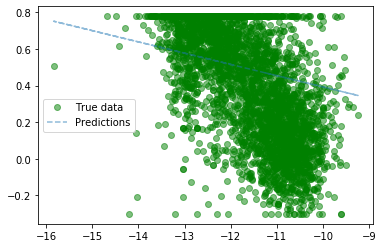

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
#Prepare Data

sSFR=SFR/mass #Calculating sSFR

log_sSFR=np.log10(sSFR)

log_sSFR=np.array(log_sSFR,dtype=np.float32).reshape(-1,1) #Changing data from pd dataframe to arrays to make it easier to feed to Torch 
n=np.array(n,dtype=np.float32).reshape(-1,1)

n=np.log10(n)


#Model 
inputDim=1
outputDim=1 
learningRate=0.01

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

#Training Loop
epochs=100


for epoch in range(epochs): #Forward Pass and loss
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(log_sSFR).cuda())
        labels = Variable(torch.from_numpy(n).cuda())
    else:
        inputs = Variable(torch.from_numpy(log_sSFR))
        labels = Variable(torch.from_numpy(n))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters, (backward pass)
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(log_sSFR).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(log_sSFR))).data.numpy()
    print(predicted)



plt.clf()
plt.plot(log_sSFR, n, 'go', label='True data', alpha=0.5)
plt.plot(log_sSFR, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
plt.figure()
